In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision.transforms.functional import rotate
from torch.utils.data import Dataset, DataLoader

In [15]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, functional as F
import torch
from torch.utils.data import Dataset

class RotatedMNIST(Dataset):
    def __init__(self, root="./data", train=True, digits=(1, 2), angles=None):
        self.mnist = MNIST(root=root, train=train, download=True, transform=ToTensor())
        self.indices = [i for i, (_, label) in enumerate(self.mnist) if label in digits]
        self.angles = angles if angles else list(range(0, 360, 30))  # Rotations in steps of 30 degrees

    def __len__(self):
        return len(self.indices) * len(self.angles)

    def __getitem__(self, idx):
        img_idx = self.indices[idx // len(self.angles)]
        angle = self.angles[idx % len(self.angles)]
        img, label = self.mnist[img_idx]

        img_rotated = F.rotate(img, angle)
        return img, img_rotated, torch.tensor(angle / 360.0)  # Normalize angle

# Define dataset and DataLoader
train_dataset = RotatedMNIST(root="./data", train=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] range automatically
])

# Load Train and Test Datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)  # Fix: Define test_dataset

# Define Data Loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Fix: Now test_dataset is defined


In [8]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In case running the code for the first time then train the whole model

In [10]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


print("Starting VAE Training...")
for epoch in range(20):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')

Starting VAE Training...
Epoch 1, Loss: 183.2755
Epoch 2, Loss: 123.7812


KeyboardInterrupt: 

if the model is already saved then use this code


In [11]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the VAE model
vae = VAE().to(device)

# Load the pre-trained weights
checkpoint = torch.load("vae_mnist.pth", map_location=device)
vae.load_state_dict(checkpoint)

# Set model to evaluation mode
vae.eval()

print("Pre-trained VAE model loaded successfully!")


Pre-trained VAE model loaded successfully!


In [12]:
torch.save(model.state_dict(), "vae_mnist.pth")


In [13]:
model.load_state_dict(torch.load("vae_mnist.pth"))
model.train()  


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=256, bias=True)
    (6): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=32, bias=True)
  (fc_var): Linear(in_features=256, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3136, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
for epoch in range(21, 31):  
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch}, Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch 21, Loss: 97.4159
Epoch 22, Loss: 97.3002
Epoch 23, Loss: 97.1484
Epoch 24, Loss: 97.0593
Epoch 25, Loss: 96.8989
Epoch 26, Loss: 96.7997
Epoch 27, Loss: 96.7098
Epoch 28, Loss: 96.6413
Epoch 29, Loss: 96.5300
Epoch 30, Loss: 96.4831


In [16]:
# Extract latent representations for training the MLP
latent_vectors = []
rotated_latent_vectors = []
angles = []

with torch.no_grad():
    for img, img_rotated, angle in train_loader:
        img, img_rotated = img.to(device), img_rotated.to(device)

        mu_original, _ = vae.encode(img)  # Encode original image
        mu_rotated, _ = vae.encode(img_rotated)  # Encode rotated image

        latent_vectors.append(mu_original.cpu())
        rotated_latent_vectors.append(mu_rotated.cpu())
        angles.append(angle.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0)
rotated_latent_vectors = torch.cat(rotated_latent_vectors, dim=0)
angles = torch.cat(angles, dim=0)


# Define the MLP for learning transformations in latent space
class MLP(nn.Module):
    def __init__(self, latent_dim=32):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Output should match latent dimension
        )

    def forward(self, x):
        return self.model(x)

# Initialize MLP
mlp = MLP(latent_dim=32).to(device)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train MLP
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    for i in range(len(latent_vectors)):
        z = latent_vectors[i].to(device)
        z_rotated = rotated_latent_vectors[i].to(device)

        mlp_optimizer.zero_grad()
        
        z_predicted = mlp(z)  # Predict rotated latent space
        loss = criterion(z_predicted, z_rotated)  # Compare with actual rotated latent vector
        
        loss.backward()
        mlp_optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(latent_vectors):.4f}")

# Save trained MLP model
torch.save(mlp.state_dict(), "mlp_symmetry.pth")


Epoch 1/20, Loss: 0.4625
Epoch 2/20, Loss: 0.4607
Epoch 3/20, Loss: 0.4605
Epoch 4/20, Loss: 0.4604
Epoch 5/20, Loss: 0.4603
Epoch 6/20, Loss: 0.4603
Epoch 7/20, Loss: 0.4602
Epoch 8/20, Loss: 0.4603
Epoch 9/20, Loss: 0.4603
Epoch 10/20, Loss: 0.4602
Epoch 11/20, Loss: 0.4602
Epoch 12/20, Loss: 0.4602
Epoch 13/20, Loss: 0.4602
Epoch 14/20, Loss: 0.4602
Epoch 15/20, Loss: 0.4602
Epoch 16/20, Loss: 0.4602
Epoch 17/20, Loss: 0.4602
Epoch 18/20, Loss: 0.4602
Epoch 19/20, Loss: 0.4602
Epoch 20/20, Loss: 0.4602


In [ ]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        self.encoder_fc = nn.Linear(12544, 256)  
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256)
        self.decoder_upsample = nn.Linear(256, 12544)  

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)  
        x = self.encoder_fc(x)
        return self.fc_mu(x), self.fc_var(x)

    def decode(self, z):
        x = self.decoder_fc(z)
        x = self.decoder_upsample(x)
        x = x.view(-1, 64, 14, 14)  
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var  

In [ ]:
vae = VAE()
checkpoint = torch.load("vae_mnist.pth", map_location=device)
model_dict = vae.state_dict()

filtered_checkpoint = {k: v for k, v in checkpoint.items() if k in model_dict and v.shape == model_dict[k].shape}

model_dict.update(filtered_checkpoint)
vae.load_state_dict(model_dict)


<All keys matched successfully>

In [ ]:
with torch.no_grad():
    recon_x, _, _ = vae(sample_input)  
print(recon_x.shape)  


torch.Size([1, 1, 28, 28])


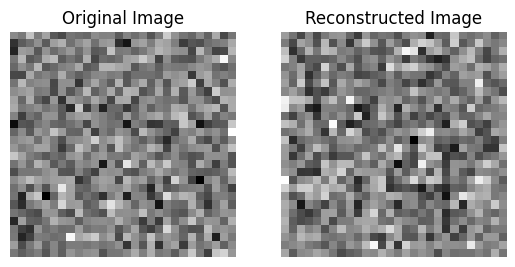

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    recon_x, _, _ = vae(sample_input)

input_img = sample_input.cpu().squeeze().numpy()
recon_img = recon_x.cpu().squeeze().numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(input_img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(recon_img, cmap='gray')
ax[1].set_title("Reconstructed Image")
ax[1].axis("off")

plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms.functional import rotate
from torchvision.transforms import ToTensor

# Load trained VAE model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
checkpoint = torch.load("vae_mnist.pth", map_location=device)
vae.load_state_dict(checkpoint)
vae.eval()

# Define MLP model for transformation learning
class MLP(nn.Module):
    def __init__(self, latent_dim=32):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

# Initialize MLP
mlp = MLP(latent_dim=32).to(device)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Prepare Rotated MNIST Dataset (digits 1 and 2 only)
class RotatedMNIST(Dataset):
    def __init__(self, root, train=True, digits=(1, 2)):
        self.mnist = MNIST(root=root, train=train, download=True, transform=ToTensor())
        self.indices = [i for i, (_, label) in enumerate(self.mnist) if label in digits]
        self.angles = list(range(0, 360, 30))

    def __len__(self):
        return len(self.indices) * len(self.angles)

    def __getitem__(self, idx):
        img_idx = self.indices[idx // len(self.angles)]
        angle = self.angles[idx % len(self.angles)]
        img, label = self.mnist[img_idx]

        img_rotated = rotate(img, angle)
        return img, img_rotated, angle  # Return original, rotated, and angle

# DataLoader
train_dataset = RotatedMNIST(root="./data", train=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train MLP
num_epochs = 10  # Adjust if needed
vae.eval()
mlp.train()

for epoch in range(num_epochs):
    total_loss = 0
    for img, img_rotated, angle in train_loader:
        img, img_rotated = img.to(device), img_rotated.to(device)

        # Encode images to latent space
        with torch.no_grad():
            _, mu_original, _ = vae(img)
            _, mu_rotated, _ = vae(img_rotated)

        # Train MLP to learn the transformation in latent space
        optimizer.zero_grad()
        predicted_rotated = mlp(mu_original)
        loss = criterion(predicted_rotated, mu_rotated)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

# Save the trained MLP model
torch.save(mlp.state_dict(), "mlp_rotation_mapper.pth")

# Test the trained MLP (Example)
with torch.no_grad():
    img, img_rotated, _ = train_dataset[0]
    img = img.unsqueeze(0).to(device)  # Add batch dimension
    _, mu_original, _ = vae(img)
    predicted_latent = mlp(mu_original)
    reconstructed_rotated = vae.decode(predicted_latent)

    print("Original image and predicted rotated image processed.")


c:\Users\HP\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


NameError: name 'VAE' is not defined